In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
multi = pd.read_csv('../input/multipleChoiceResponses.csv')

multi.head()

['SurveySchema.csv', 'freeFormResponses.csv', 'multipleChoiceResponses.csv']


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,Q7_OTHER_TEXT,Q8,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q11_OTHER_TEXT,Q12_MULTIPLE_CHOICE,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,...,Q46,Q47_Part_1,Q47_Part_2,Q47_Part_3,Q47_Part_4,Q47_Part_5,Q47_Part_6,Q47_Part_7,Q47_Part_8,Q47_Part_9,Q47_Part_10,Q47_Part_11,Q47_Part_12,Q47_Part_13,Q47_Part_14,Q47_Part_15,Q47_Part_16,Q48,Q49_Part_1,Q49_Part_2,Q49_Part_3,Q49_Part_4,Q49_Part_5,Q49_Part_6,Q49_Part_7,Q49_Part_8,Q49_Part_9,Q49_Part_10,Q49_Part_11,Q49_Part_12,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,In what industry is your current employer/cont...,In what industry is your current employer/cont...,How many years of experience do you have in yo...,What is your current yearly compensation (appr...,Does your current employer incorporate machine...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,What is the primary tool that you use at work ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,...,Approximately what percent of your data projec...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,What methods do you prefer for explaining and/...,"Do you consider ML models to be ""black boxes"" ...",What tools and methods do you use to make your...,What tools and methods do you use to make your...,What tools and methods do you use to make your...,What tools and methods do you use to make your...,What tools and methods do you use to make your...,What tools and method

Questions of interest:

Undergraduate major and how it relates to salary?

How skills in ML and programming affect salary?

How much does understanding ML outputs affect success?

In [2]:
#Remove the first row which contains the question text
multi = multi.drop(multi.index[0])

In [3]:
multi.shape


(23859, 395)

In [4]:
#Salaries in the CSV are listed as ranges. For calcuation I took the mid point of each range.
def salary_convert(salary):
    avg = salary
    if isinstance(salary, str):
        if  '-' in salary:
            range = salary.split('-')
            avg = (int(range[0]) + int(range[1].split(',')[0]))*500
        
        else:
            avg = np.NaN
    return avg
multi['Salary'] = multi.Q9.apply(salary_convert)

In [5]:
major_salary = multi.groupby(['Q5'], as_index = False).Salary.mean()
major_salary

,Q5,Salary
0,"A business discipline (accounting, economics, ...",59463.869464
1,"Computer science (software engineering, etc.)",39327.443355
2,Engineering (non-computer focused),51290.158601
3,Environmental science or geology,52413.793103
4,Fine arts or performing arts,94870.689655
5,"Humanities (history, literature, philosophy, e...",77523.809524
6,I never declared a major,46856.060606
7,"Information technology, networking, or system ...",34264.475743
8,Mathematics or statistics,54376.208897
9,"Medical or life sciences (biology, chemistry, ...",55864.600326


[Text(0,0,'A business discipline (accounting, economics, finance, etc.)'),
 Text(0,0,'Computer science (software engineering, etc.)'),
 Text(0,0,'Engineering (non-computer focused)'),
 Text(0,0,'Environmental science or geology'),
 Text(0,0,'Fine arts or performing arts'),
 Text(0,0,'Humanities (history, literature, philosophy, etc.)'),
 Text(0,0,'I never declared a major'),
 Text(0,0,'Information technology, networking, or system administration'),
 Text(0,0,'Mathematics or statistics'),
 Text(0,0,'Medical or life sciences (biology, chemistry, medicine, etc.)'),
 Text(0,0,'Other'),
 Text(0,0,'Physics or astronomy'),
 Text(0,0,'Social sciences (anthropology, psychology, sociology, etc.)')]

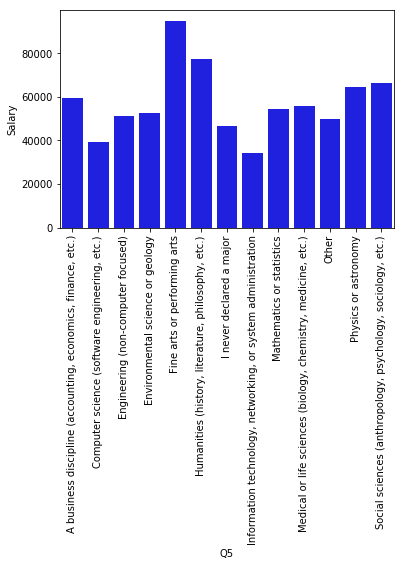

In [6]:
#ms_graph = convert(major_salary, 'Major')
ms = sns.barplot(x = 'Q5', y= 'Salary' , data = major_salary, color = 'blue')
ms.set_xticklabels(major_salary['Q5'], rotation=90)

These are certainly surprising results.  CS/IT majors have the two lowest average salaries while fine arts/performing arts majors have some of the highest. Let's try to find some other factors that might be skewing our results.

In [7]:
multi.groupby(['Q5']).Salary.value_counts()


Q5                                                            Salary  
A business discipline (accounting, economics, finance, etc.)  5000.0       228
                                                              15000.0      140
                                                              25000.0      112
                                                              112500.0     107
                                                              55000.0      104
                                                              35000.0      103
                                                              45000.0       86
                                                              65000.0       83
                                                              75000.0       74
                                                              95000.0       66
                                                              85000.0       58
                                                            

Here we see a large number of 5000's in the computer science majors. These are significant not only because the number is so small but because it is actually the range 0-10,000 meaning the people here could be unpaid such as students.

In [8]:
#Removing rows where the answer to question 6 or 7 indicates they are a student
mask = multi['Q6'] == 'Student'
mask2 = multi['Q7'] == 'I am a student'
multi_no_students = multi[~mask]
multi_no_students_2 = multi_no_students[~mask2]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [9]:
multi_no_students_2.groupby(['Q5']).mean()['Salary']

Q5
A business discipline (accounting, economics, finance, etc.)     65131.463628
Computer science (software engineering, etc.)                    48843.157182
Engineering (non-computer focused)                               59338.416134
Environmental science or geology                                 60902.777778
Fine arts or performing arts                                     99245.283019
Humanities (history, literature, philosophy, etc.)               82708.333333
I never declared a major                                         53973.214286
Information technology, networking, or system administration     42606.157113
Mathematics or statistics                                        62893.274854
Medical or life sciences (biology, chemistry, medicine, etc.)    65728.105906
Other                                                            61300.813008
Physics or astronomy                                             71762.907609
Social sciences (anthropology, psychology, sociology, etc.)  

This is better but still not close to what we would expect. Let's try to find something else affecting these results.

In [10]:
multi.Q5.value_counts()

Computer science (software engineering, etc.)                    9430
Engineering (non-computer focused)                               3705
Mathematics or statistics                                        2950
A business discipline (accounting, economics, finance, etc.)     1791
Physics or astronomy                                             1110
Information technology, networking, or system administration     1029
Medical or life sciences (biology, chemistry, medicine, etc.)     871
Other                                                             770
Social sciences (anthropology, psychology, sociology, etc.)       554
Humanities (history, literature, philosophy, etc.)                269
Environmental science or geology                                  253
I never declared a major                                          128
Fine arts or performing arts                                       87
Name: Q5, dtype: int64

CS majors are by far the most prevalent. Let's see where they are from. (Also worth noting here there are 87 Fine Arts majors. We'll use this later.)

In [11]:
multi[multi['Q5'] == 'Computer science (software engineering, etc.)'].Q3.value_counts()


India                                                   2361
United States of America                                1201
China                                                    715
Other                                                    498
Brazil                                                   389
Russia                                                   333
Germany                                                  258
France                                                   228
Canada                                                   187
Spain                                                    179
United Kingdom of Great Britain and Northern Ireland     168
Turkey                                                   162
Japan                                                    161
I do not wish to disclose my location                    156
Italy                                                    140
Pakistan                                                 122
Poland                  

From previous projects I know that location can have a profound impact on wages. Let's see if we can find a way to seperate out low-wage countries from high-wage ones.

In [12]:
multi_no_students_2.groupby(['Q3']).mean()['Salary']

Q3
Argentina                                                26620.879121
Australia                                                95219.072165
Austria                                                  49852.941176
Bangladesh                                               17222.222222
Belarus                                                  22692.307692
Belgium                                                  54838.709677
Brazil                                                   31783.295711
Canada                                                   76897.506925
Chile                                                    43431.372549
China                                                    33238.758030
Colombia                                                 23409.090909
Czech Republic                                           35000.000000
Denmark                                                  84880.952381
Egypt                                                    14551.282051
Finland          

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


TypeError: can't multiply sequence by non-int of type 'float'

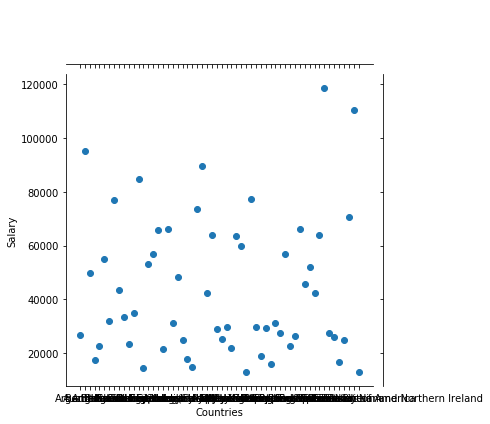

In [13]:
country_income = pd.DataFrame(multi_no_students_2.groupby(['Q3']).mean()['Salary'])
country_income['Countries'] = country_income.index
sns.jointplot(x = 'Countries', y="Salary", data=country_income)

40,000 looks like a good cutoff to me

In [14]:
income_by_country = multi_no_students_2.groupby(['Q3']).mean()['Salary']
income_by_country
mns = multi_no_students_2

high_income = [k for k, v in income_by_country.items() if v > 40000]

def income_level(country_name):
    if country_name in high_income:
        return 1
    else:
        return 0
    

#mns['Q3'].apply(income_level)[:5]
mns['income_region'] = mns["Q3"].apply(income_level)


multi_high = mns[mns['income_region'] == 1]
multi_low = mns[mns['income_region'] == 0]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [15]:
major_salary_high = multi_high.groupby(['Q5'], as_index = False).Salary.mean()
major_salary_high

,Q5,Salary
0,"A business discipline (accounting, economics, ...",84393.139842
1,"Computer science (software engineering, etc.)",81606.950431
2,Engineering (non-computer focused),88937.737643
3,Environmental science or geology,78341.836735
4,Fine arts or performing arts,100104.166667
5,"Humanities (history, literature, philosophy, e...",92751.572327
6,I never declared a major,70405.405405
7,"Information technology, networking, or system ...",70472.636816
8,Mathematics or statistics,83588.095238
9,"Medical or life sciences (biology, chemistry, ...",79832.439678


[Text(0,0,'A business discipline (accounting, economics, finance, etc.)'),
 Text(0,0,'Computer science (software engineering, etc.)'),
 Text(0,0,'Engineering (non-computer focused)'),
 Text(0,0,'Environmental science or geology'),
 Text(0,0,'Fine arts or performing arts'),
 Text(0,0,'Humanities (history, literature, philosophy, etc.)'),
 Text(0,0,'I never declared a major'),
 Text(0,0,'Information technology, networking, or system administration'),
 Text(0,0,'Mathematics or statistics'),
 Text(0,0,'Medical or life sciences (biology, chemistry, medicine, etc.)'),
 Text(0,0,'Other'),
 Text(0,0,'Physics or astronomy'),
 Text(0,0,'Social sciences (anthropology, psychology, sociology, etc.)')]

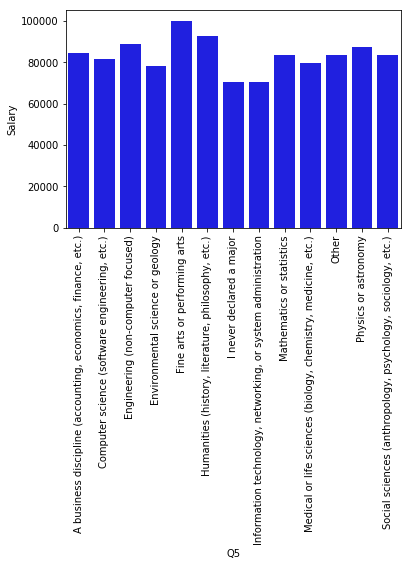

In [16]:
msh = sns.barplot(x = 'Q5', y= 'Salary' , data = major_salary_high, color = 'blue')
msh.set_xticklabels(major_salary_high['Q5'], rotation=90)

In [17]:
multi_low.groupby(['Q5']).mean()['Salary']

Q5
A business discipline (accounting, economics, finance, etc.)     27010.443864
Computer science (software engineering, etc.)                    25200.233281
Engineering (non-computer focused)                               27596.839959
Environmental science or geology                                 23750.000000
Fine arts or performing arts                                     91000.000000
Humanities (history, literature, philosophy, etc.)               34318.181818
I never declared a major                                         21973.684211
Information technology, networking, or system administration     21861.111111
Mathematics or statistics                                        29969.696970
Medical or life sciences (biology, chemistry, medicine, etc.)    21144.067797
Other                                                            23759.124088
Physics or astronomy                                             27513.157895
Social sciences (anthropology, psychology, sociology, etc.)  

As for Fine Arts majors, our highest earners, we saw earlier they make up 87 of our 23859 entries which is probably reason enough to dismiss it. But let's look at one other thing.

In [18]:
multi.groupby(['Q5']).Q4.value_counts()

Q5                                                             Q4                                                               
A business discipline (accounting, economics, finance, etc.)   Master’s degree                                                      1015
                                                               Bachelor’s degree                                                     510
                                                               Doctoral degree                                                       150
                                                               Some college/university study without earning a bachelor’s degree      54
                                                               Professional degree                                                    52
                                                               I prefer not to answer                                                 10
Computer science (software engineering, etc.)    

Of our 87 Fine Arts majors only 21 of them definitely have a Bachelor's degree and no graduate degree. So how much their undergraduate major was a factor is even harder to determine. In fact a lot of folks in these majors have Masters degrees and since we only have undergraduate majors available we're limited in what we can say (as I'll discuss in the blog this can be a good thing).  Another factor could be skills but we are going to consider this for the entire dataset next.

First the relationship of coding to salary.

In [19]:
coding = multi.groupby(['Q24'], as_index = False).Salary.mean()
myorder = [8,9,7,0,3,6,1,2,4]
#Need to reorder because default order was nonsensical. We'll need to do the same on ML question
ordered = coding.reindex(myorder, axis = 0)
ordered

,Q24,Salary
8,I have never written code and I do not want to...,55000.000000
9,I have never written code but I want to learn,32200.203252
7,< 1 year,26220.950103
0,1-2 years,36836.505419
3,3-5 years,55247.070003
6,5-10 years,76862.994350
1,10-20 years,99913.310962
2,20-30 years,115715.811966
4,30-40 years,146481.481481


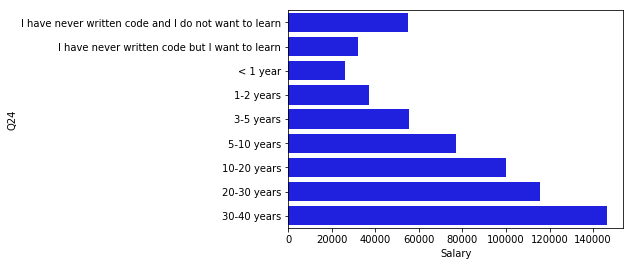

In [20]:
#code_graph = convert(coding, 'Coding Experience')
#code_graph
code = sns.barplot(x = 'Salary', y= 'Q24' , data = ordered, color = 'blue')
#code.set_xticklabels(ordered['Q24'], rotation=90)

We see that over time coding pays off but early on programming doesn't necessarily produce the highest salary early in career. Let's do the same comparison for Machine Learning.

In [21]:
multi.groupby(['Q25'], as_index = False).Salary.mean()
ml_order = [8,9,7,0,2,4,5,6,1,3]

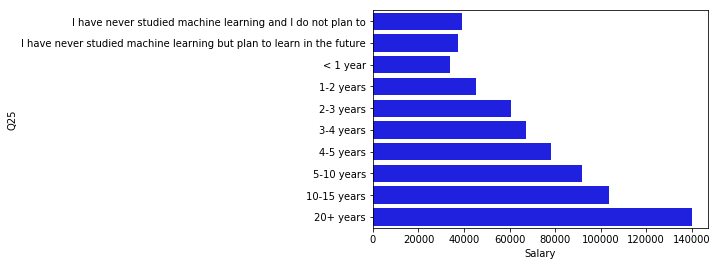

In [22]:
ml_graph = multi.groupby(['Q25'], as_index = False).Salary.mean()
ml_ordered = ml_graph.reindex(ml_order)
ml = sns.barplot(x = 'Salary', y= 'Q25' , data = ml_ordered, color = 'blue')


Much more immediate results.

Finally our question about whether being able to interpret data influences success.

[Text(0,0,'I am confident that I can explain the outputs of most if not all ML models'),
 Text(0,0,'I am confident that I can understand and explain the outputs of many but not all ML models'),
 Text(0,0,'I do not know; I have no opinion on the matter'),
 Text(0,0,'I view ML models as "black boxes" but I am confident that experts are able to explain model outputs'),
 Text(0,0,'Yes, most ML models are "black boxes"')]

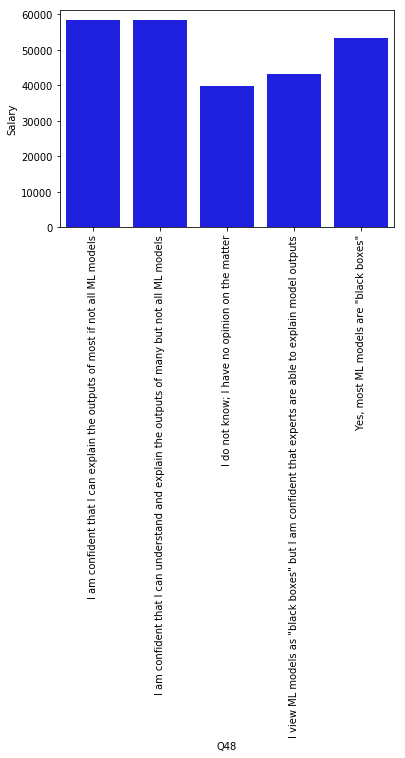

In [23]:
multi.groupby(['Q48']).Salary.mean()
ml_graph = multi.groupby(['Q48'], as_index = False).Salary.mean()
ml = sns.barplot(x = 'Q48', y= 'Salary' , data = ml_graph, color = 'blue')
ml.set_xticklabels(ml_graph['Q48'], rotation=90)

This is a fascinating graph because it seems to suggest a pattern but what exactly that pattern is is uncertain. My best theory is that the "Yes, most ML models are black boxes" group is a mixture of people working with less inpretable models(and making higher salaries) and people who are less knowledgable (and making lower salaries).  We'll need to define a couple of functions to help us explore this data.

In [24]:
def super_groupby (df,comparison,base_text, part_max):
    '''This function is designed to find value counts from multiple columns and group them by the responses in a single column.
        The design is built specifically around the column name formats used in the multipleChoiceResponses.csv file. It iterates
        the mulitple column comparing them to the single column and concatenates the results""
    
        Keyword Arguements:
        df = A DataFrame containing the relevant data
        comparison = A single column
        base_text = The basic format for the columns to be iterated (should include a {} in place of a part number)
        part_max = The highest number for np.arange (should be one more than the highest numbered part # in the columns or,
                more simply, one more than the number of columns)
        '''
    parts = np.arange(1,part_max)

    column_list = []
    for part in parts:
        column_list.append(base_text.format(part))
    count_list = []
    for column in column_list:
        df = df.rename(columns={column: 'current'})
        count = df.groupby([comparison]).current.value_counts()
        df = df.rename(columns={'current': column})
        count_list.append(count)
    concatenated = pd.concat(count_list, sort =False)
    return concatenated.sort_index()



In [25]:
def plot_supergroup(supergroup, column = 'current'):
    '''A function for plotting value count groupby's primarily those generated by super_groupby
    
    Keyword Arguements:
    supergroup = A Pandas Series generated by either groupby or super_groupby
    column = The name of the column generated by groupby or super_groupby (which is named 
            'current' if generated by super_groupby thus that is the default)
    '''
    df = pd.DataFrame(supergroup)
    df = df.rename(columns={column:'Count'})
    df.reset_index(inplace=True)
    ax2= sns.barplot(y = 'Q48', x = 'Count', hue = column, data=df)
    ax2.legend(loc=4, bbox_to_anchor=(0.5, 1.0))

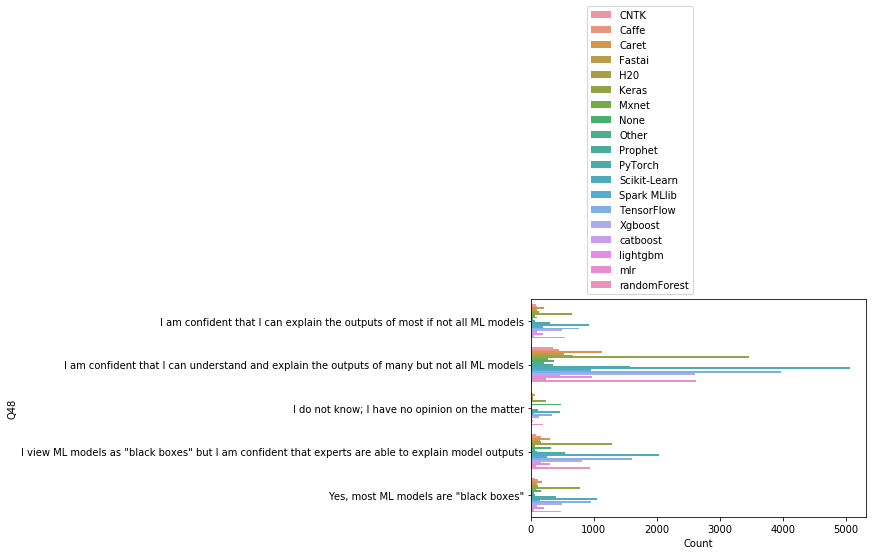

In [26]:
frameworks = super_groupby(multi,'Q48','Q19_Part_{}',20)
plot_supergroup(frameworks)

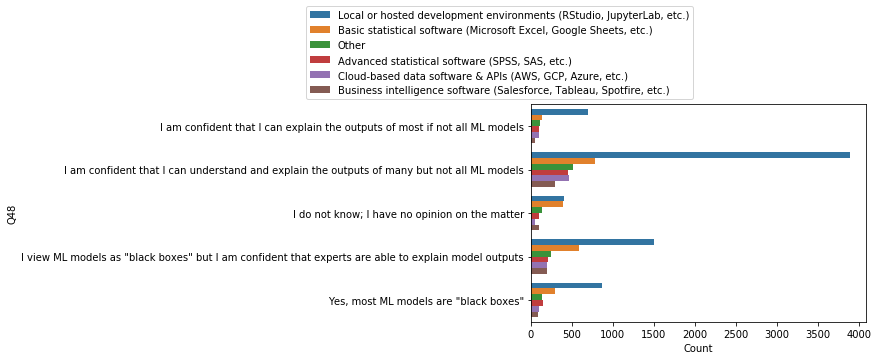

In [27]:
analysis_tools = multi.groupby(['Q48']).Q12_MULTIPLE_CHOICE.value_counts()
plot_supergroup(analysis_tools,'Q12_MULTIPLE_CHOICE')

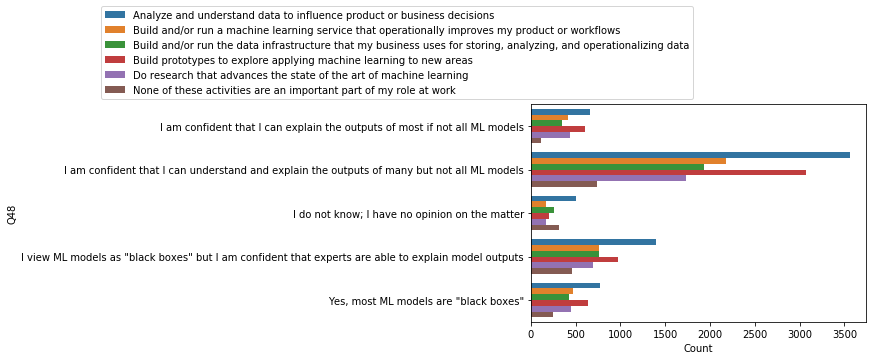

In [28]:
role = super_groupby(multi,'Q48','Q11_Part_{}',7)
plot_supergroup(role)
#df_role = pd.DataFrame(role)
#df_role = df_role.rename(columns={'current':'Count'})
#df_role.reset_index(inplace=True)
#df_role


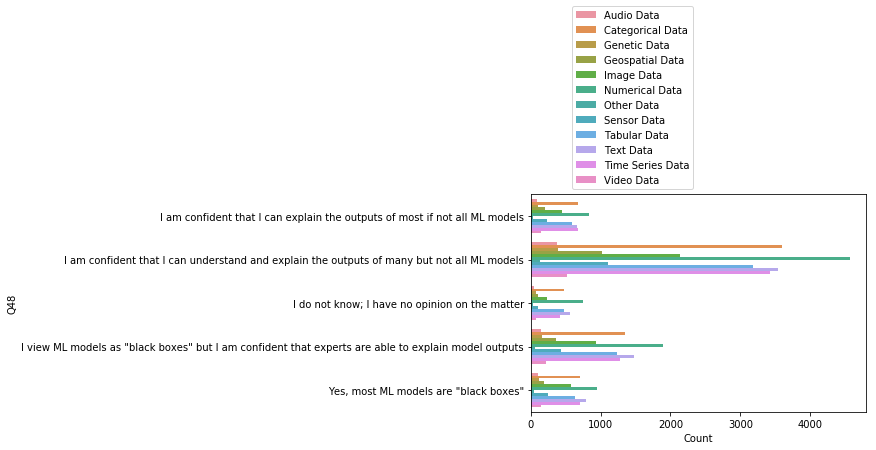

In [29]:
dtype = super_groupby(multi,'Q48','Q31_Part_{}',13)
plot_supergroup(dtype)

There doesn't seem like much to draw here. Perhaps we just don't have enough to make a solid conclusion. I'll discuss this more in the blog.